# IMPTOX - Quick Gradient SHAP Example

SHAP illustrates how each feature contributes to the prediction by indicating whether it pushes the outcome higher or lower compared to the baseline. Positive SHAP values suggest an upward influence on the prediction, while negative values indicate a downward influence, providing a clear understanding of each feature's impact direction.

Dataframe should have one output named OUT

Data should be full numerical

Simple light example

Automatically split and model trained. 


In [20]:
import seaborn as sns
import pandas as pd
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [21]:
os.makedirs( f"./notebooks/mlp/saved_models", exist_ok=True)
os.makedirs( f"./notebooks/mlp/plots", exist_ok=True)

SAVE_PATH = "./notebooks/mlp"
PATH_SIMPLE_MODEL_LOSS = "./notebooks/mlp/plots/simple_model_1_loss.png"

In [22]:
# Download latest version and import dataframe. Replace this with your own dataset

path = kagglehub.dataset_download("gargmanas/pima-indians-diabetes")

root_dir = pl.Path("../datasets/PimaDiabetes/")

print("Path to dataset files:", path )

df = pd.read_csv(path + '/pima-indians-diabetes.csv')
df.columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','OUT']

df

Path to dataset files: /home/twg/.cache/kagglehub/datasets/gargmanas/pima-indians-diabetes/versions/1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,OUT
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
762,10,101,76,48,180,32.9,0.171,63,0
763,2,122,70,27,0,36.8,0.340,27,0
764,5,121,72,23,112,26.2,0.245,30,0
765,1,126,60,0,0,30.1,0.349,47,1


## Split the dataframe into train, test and validation sets

In [23]:
# Train-test-val split of df
train_df, test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(test_df, test_size=0.5)

# Split X and y
X_train, y_train = train_df.drop(columns=['OUT']), train_df['OUT']
X_test, y_test = test_df.drop(columns=['OUT']), test_df['OUT']
X_val, y_val = val_df.drop(columns=['OUT']), val_df['OUT']


## Set the hyper parameters for the model

Here we set the different parameters such as: 
- input size (number of features, deduced from X)
- epoch (number of train cycles)
- learning rate 

In [24]:
# Hyper parameters

TRAIN_SIMPLE_MODEL = True # Set to True to train the simple model, False to load the model from file
MLP_INPUT_SIZE = len(X_train.columns)
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# If you have cuda available, it will automatically use your GPU for a faster computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data loaders

The MLP needs data loaders that encapsulate our dataframe in order to distribute our data as tensors (matrices) during the training process. These classes bellow takes care of this. 

In [25]:
# Dataset class
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait before stopping
counter = 0

# Custom Dataloaders
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainData(torch.FloatTensor(X_train.values), 
                       torch.FloatTensor(y_train.values))

class ValData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
val_data = ValData(torch.FloatTensor(X_val.values),
                   torch.FloatTensor(y_val.values))
   
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

test_data = TestData(torch.FloatTensor(X_test.values),
                     torch.FloatTensor(y_test.values))


train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)


## MLP definition

Here we define our MLP with different neuron layers. Input size matches the number of features and the output in this case is one variable (0/1). 

In [26]:
# Define the model, loss function, optimizer and metric function
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is MLP_INPUT_SIZE.
        self.layer_1 = nn.Linear(MLP_INPUT_SIZE, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.5)  # Randomly zero out neurons to avoid overfitting

        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

simple_model_1 = BinaryClassification()
simple_model_1.to(device)

cw = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
    )
cw = torch.tensor(cw, dtype=torch.float32)

# Binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss(pos_weight=cw[1])
optimizer = optim.Adam(simple_model_1.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # L2 regularization

def binary_acc(y_pred, y_test):
    '''
    Calculate the accuracy of the model given the predictions and the true labels
    '''
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## Training

The MLP is trained according to the preset hyper parameters. 

/mnt/c/Users/TSchowing/Desktop/repositories/IMPTOX_XAI
Epoch 1: Validation loss improved. Saving the model.
Epoch 1: Train Loss: 0.86058, Train Acc: 53.444, Val Loss: 0.79535, Val Acc: 61.000
/mnt/c/Users/TSchowing/Desktop/repositories/IMPTOX_XAI
Epoch 2: Validation loss improved. Saving the model.
Epoch 2: Train Loss: 0.83701, Train Acc: 53.444, Val Loss: 0.79199, Val Acc: 59.000
/mnt/c/Users/TSchowing/Desktop/repositories/IMPTOX_XAI
Epoch 3: Validation loss improved. Saving the model.
Epoch 3: Train Loss: 0.79845, Train Acc: 60.889, Val Loss: 0.78337, Val Acc: 62.000
/mnt/c/Users/TSchowing/Desktop/repositories/IMPTOX_XAI
Epoch 4: Validation loss improved. Saving the model.
Epoch 4: Train Loss: 0.80689, Train Acc: 58.889, Val Loss: 0.77490, Val Acc: 64.000
/mnt/c/Users/TSchowing/Desktop/repositories/IMPTOX_XAI
Epoch 5: Validation loss improved. Saving the model.
Epoch 5: Train Loss: 0.78656, Train Acc: 58.778, Val Loss: 0.76116, Val Acc: 66.000
/mnt/c/Users/TSchowing/Desktop/repositor

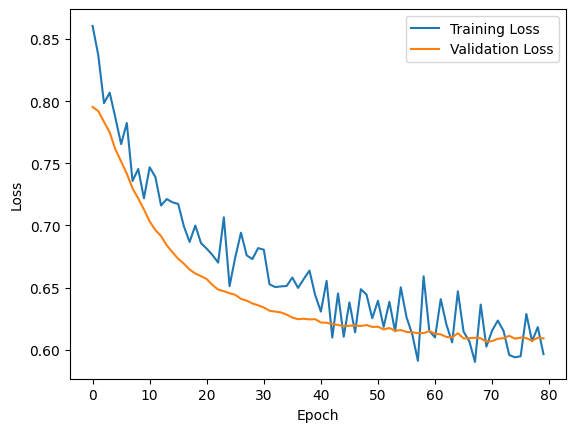

In [27]:


if TRAIN_SIMPLE_MODEL:
    
    # Initialize lists to track losses
    train_losses = []
    val_losses = []

    for e in range(1, EPOCHS+1):
        simple_model_1.train()
        train_loss = 0
        train_acc = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = simple_model_1(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += acc.item()
            
        train_losses.append(train_loss / len(train_loader))
        
        val_loss = 0
        val_acc = 0
        simple_model_1.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = simple_model_1(X_batch)
                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))
                val_loss += loss.item()
                val_acc += acc.item()
                
        val_losses.append(val_loss / len(val_loader))
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save the best model's state_dict
            # print current directory
            print(os.getcwd())
            torch.save(simple_model_1.state_dict(), f'{SAVE_PATH}/saved_models/best_model.pt')
            print(f"Epoch {e}: Validation loss improved. Saving the model.")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {e}")
                break
        
        print(f"Epoch {e}: Train Loss: {train_loss/len(train_loader):.5f}, "
            f"Train Acc: {train_acc/len(train_loader):.3f}, "
            f"Val Loss: {val_loss/len(val_loader):.5f}, "
            f"Val Acc: {val_acc/len(val_loader):.3f}")
         
    torch.save(simple_model_1, f'{SAVE_PATH}/saved_models/simple_model_1.pt')
    
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(PATH_SIMPLE_MODEL_LOSS)
    plt.show()
    
else: 
    # Load the model
    simple_model_1 = torch.load(f'{SAVE_PATH}/saved_models/simple_model_1.pt')
    
    print("Losses saved in the file: ", PATH_SIMPLE_MODEL_LOSS)
    # Display the image in the notebook
    display(Image(filename=PATH_SIMPLE_MODEL_LOSS))
    



## Test the model 

After visualizing the training and validation loss (orange and blue) we can test the model with unseen data, here coming from our test_loader, to assess the performances of our model. 

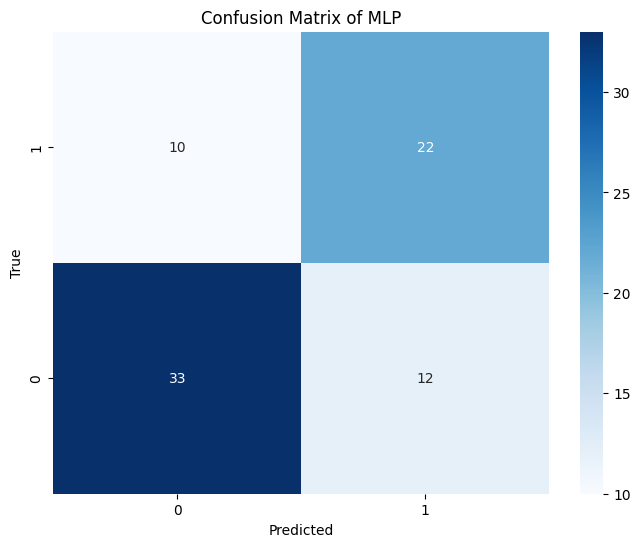

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize containers for predictions and true labels
all_preds = []
all_labels = []

simple_model_1.eval()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = torch.sigmoid(simple_model_1(X_batch))  # Apply sigmoid for probabilities
        y_pred_tag = torch.round(y_pred)  # Convert probabilities to binary predictions

        all_preds.extend(y_pred_tag.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.gca().invert_yaxis()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of MLP')
plt.savefig(SAVE_PATH + "/plots/confusion_matrix.png")
plt.show()


### Metrics

Here we calculate the metric from the above confusion matrix `cm`

In [29]:
print(cm.shape)

(2, 2)


In [30]:
def print_metrics(cm, verbose=True):
    '''
    Prints the metrics from the confusion matrix and returns a dictionary with the values.
    '''
    
    # Ensure the confusion matrix is 2x2
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
        
        accuracy, precision, recall, f1_score, specificity, balanced_accuracy, ppv = 0, 0, 0, 0, 0, 0, 0

        # Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        # Precision
        if (tp + fp) > 0:
            precision = tp / (tp + fp)
            precision_txt = f"Precision: {precision}"
            
        else:
           precision_txt = "Precision: Undefined (tp + fp is 0)"

        # Recall (Sensitivity)
        if (tp + fn) > 0:
            recall = tp / (tp + fn)
            recall_txt = f"Recall: {recall}"
        else:
            recall_txt = "Recall: Undefined (tp + fn is 0)"

        # F1 Score
        if (tp + fp) > 0 and (tp + fn) > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
            f1_txt = f"F1 Score: {f1_score}"
        else:
            f1_txt = "F1 Score: Undefined (precision + recall is 0)"
        
        # Specificity
        if (tn + fp) > 0:
            specificity = tn / (tn + fp)
            specificity_txt = f"Specificity: {specificity}"
        else:
            specificity_txt = "Specificity: Undefined (tn + fp is 0)"

        # Balanced accuracy
        if (tn + fp) > 0 and (tp + fn) > 0:
            balanced_accuracy = (recall + specificity) / 2
            balanced_accuracy_txt = f"Balanced Accuracy: {balanced_accuracy}"
        else:
            balanced_accuracy_txt = "Balanced Accuracy: Undefined (one of the denominators is 0)"
            
        # PPV
        if (tp + fp) > 0:
            ppv = tp / (tp + fp)
            ppv_txt = f"Positive Predictive Value: {ppv}"
        else:
            ppv_txt = "Positive Predictive Value: Undefined (tp + fp is 0)"
        
        if verbose:
            print("-------------------------")
            print(precision_txt)
            print(recall_txt)
            print(f1_txt)
            print(specificity_txt)
            print(balanced_accuracy_txt)
            print(ppv_txt)
            
        
        return {"Accuracy": accuracy, 
                "Precision": precision, 
                "Recall": recall, 
                "F1 Score": f1_score, 
                "Specificity": specificity, 
                "Balanced Accuracy": balanced_accuracy, 
                "PPV": ppv}
        
    else:
        print("Error: Confusion matrix is not 2x2")
        return None

metrics = print_metrics(cm)


True Negatives: 33
False Positives: 12
False Negatives: 10
True Positives: 22
-------------------------
Precision: 0.6470588235294118
Recall: 0.6875
F1 Score: 0.6666666666666667
Specificity: 0.7333333333333333
Balanced Accuracy: 0.7104166666666667
Positive Predictive Value: 0.6470588235294118


# Graduebt SHAP explanations

We reached a potentially satisfying result but now we need to understand why the model classified our test samples this way. For this we can use Gradient SHAP which will provide for each feature and for each test sample, how the feature affected the outcome. The more the feature is important, the more it will push toward 0 or 1. We can visualize this for each sample but we can also use Gradient SHAP as a global explanation by averaging all SHAP values. 

Here we average the SHAP values for True Positives, True Negatives, False Positives and True Positives as well as for all the test values alltogether. 

In [31]:
from captum.attr import GradientShap
import warnings

FILENAME_GSHAP_MLP = f"{SAVE_PATH}/plots/gradient_shap.csv"
COMPUTE_GSHAP_SIMPLE_MODEL_NEW = True

Computing Gradient SHAP for Simple Model 1
Formating 77 explanations.
12
22
10
33


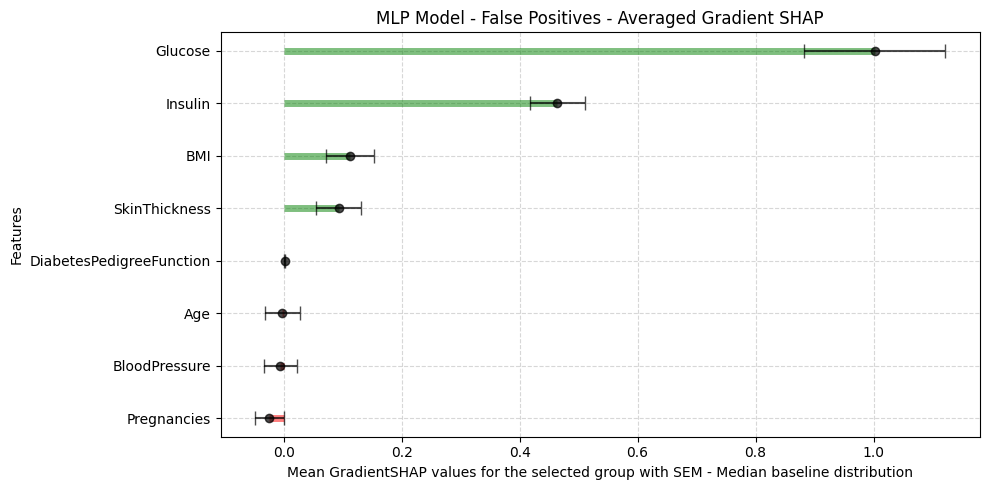

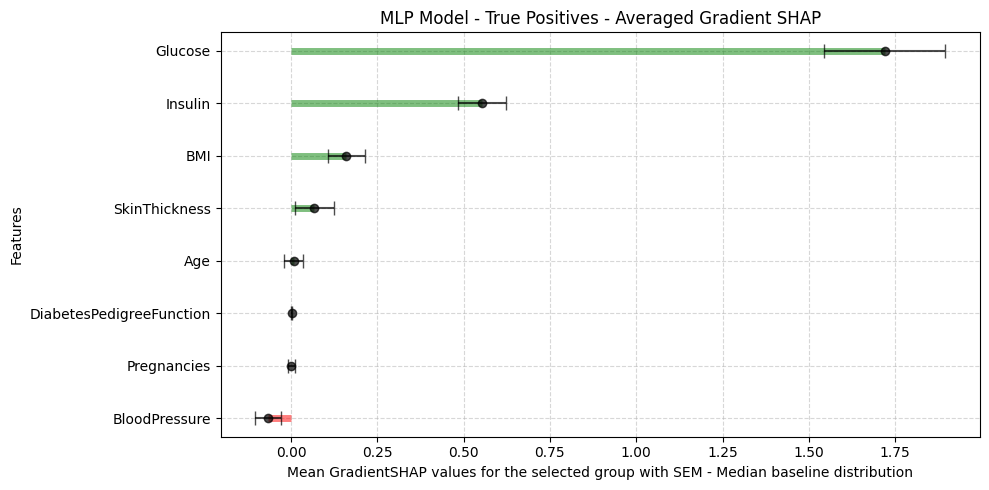

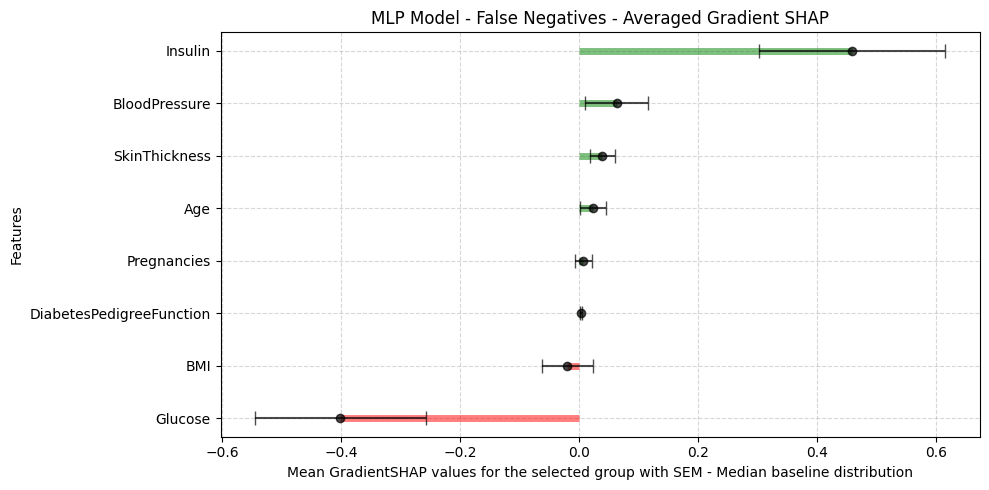

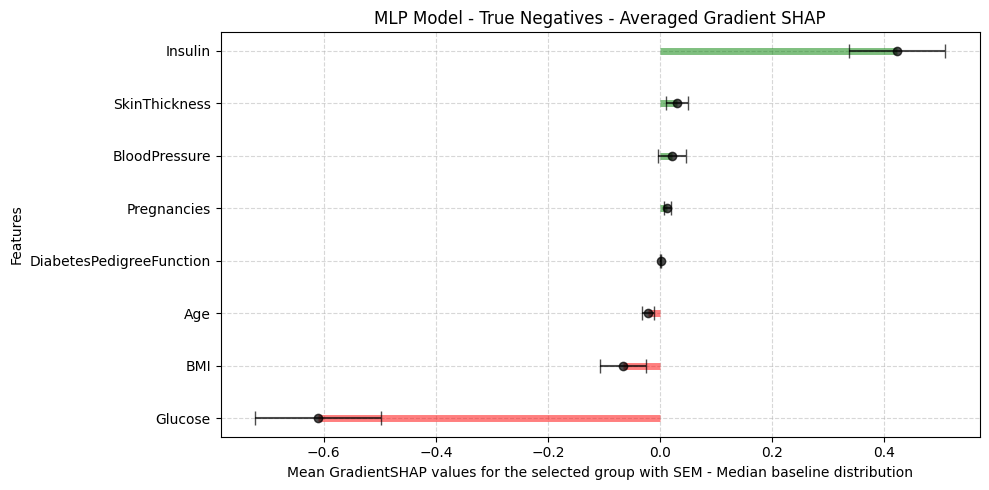

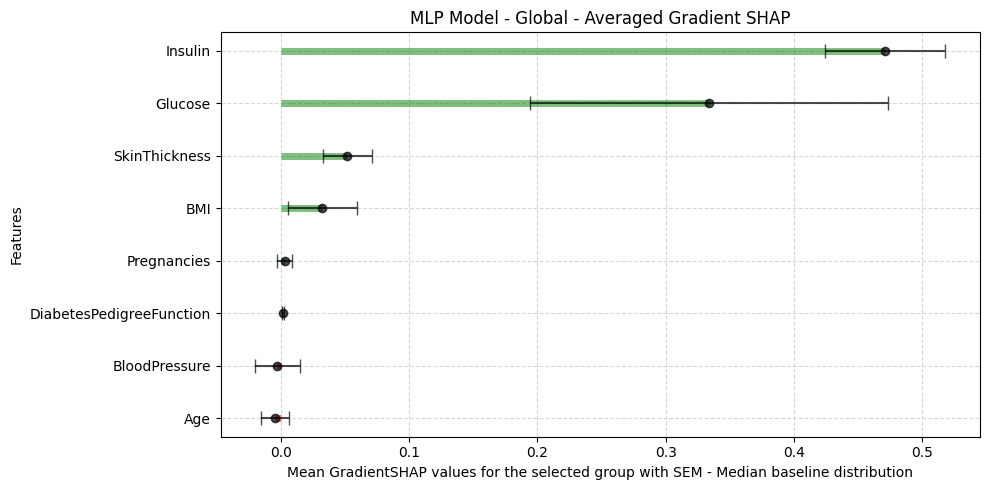

In [32]:
def plot_gradient_shap_new(exp_df_subset, title = "GSHAP", AVERAGED = True, savefig=True, savepath="", filename=""):

    
    exp_df = exp_df_subset.copy()

    if AVERAGED:
        
        
        # Add standart error of the mean to the dataframe before reducing it to a single row
        sem_exp = exp_df.sem(axis=0)
        
        
        # For averaged version (reduce to one row with average values)
        exp_df = pd.DataFrame(exp_df.mean(axis=0), columns=["GradientSHAP"])
        exp_df['lower_bound'] = exp_df["GradientSHAP"] - sem_exp.values
        exp_df['upper_bound'] = exp_df["GradientSHAP"] + sem_exp.values
        
        # Name index and add color
        exp_df.index.name = "Features"
        exp_df.reset_index(inplace=True)
        exp_df["colors"] = "red"
        exp_df.loc[exp_df["GradientSHAP"] > 0, "colors"] = "green"

        # Sort the dataframe
        exp_df = exp_df.sort_values("GradientSHAP", ascending=True)
        # Reset index after sorting for proper plotting
        exp_df.reset_index(drop=True, inplace=True)

        # Initialize a figure
        plt.figure(figsize=(10, 5))
        
        # Plotting the horizontal lines
        plt.hlines(
            y=exp_df.index, #+ i * 0.4,  # Offset for spacing between plots
            linewidth=5,
            xmin=0,
            xmax=exp_df.GradientSHAP,
            colors=exp_df.colors.values,
            alpha=0.5,
        )
        
        # Add error bars to represent the confidence intervals
        plt.errorbar(
            x=exp_df["GradientSHAP"],
            y=exp_df.index,
            xerr=[exp_df["GradientSHAP"] - exp_df["lower_bound"], exp_df["upper_bound"] - exp_df["GradientSHAP"]],
            fmt='o',
            color='black',  # Color of error bars
            alpha=0.7,
            capsize=5,  # Add caps to the error bars
        )

        # Decorations
        plt.gca().set(ylabel="Features", xlabel="Mean GradientSHAP values for the selected group with SEM - Median baseline distribution")
        plt.yticks(np.arange(len(exp_df)), exp_df.Features, fontsize=10 )  # Adjust fontsize based on number of features
        plt.title(title, fontdict={"size": 12})
        plt.grid(linestyle="--", alpha=0.5)

        # Show plot
        plt.tight_layout()
        if savefig:
            plt.savefig(f'{savepath}/{filename}.png')
        plt.show()

    else:
        
        for i, exp in exp_df.iterrows():
            # exp is a pandas series 
            
            patient_id = exp["pat_bk_x"]
            case_id = exp["cas_bk"]
            exp = exp.drop(labels=['pat_bk_x', 'cas_bk'])
            
            
            exp.sort_values(axis=0,ascending=False, inplace=True)
            exp = exp.to_frame()
            exp.columns = ["GradientSHAP"]
            exp.index.name = "Features"
            # Make index into a column
            exp.reset_index(inplace=True)
            
            exp["colors"] = "red"
            exp.loc[exp["GradientSHAP"] > 0, "colors"] = "green"
            
            print(exp)
            
            # Initialize a figure
            plt.figure(figsize=(10, 5))
            
            # Plotting the horizontal lines
            plt.hlines(
                y=exp.index, #+ i * 0.4,  # Offset for spacing between plots
                linewidth=5,
                xmin=0,
                xmax=exp.GradientSHAP,
                colors=exp.colors.values,
                alpha=0.5,
            )

            # Decorations
            plt.gca().set(ylabel="Features", xlabel="GradientSHAP")
            plt.yticks(np.arange(len(exp)), exp.Features, fontsize=10 )  # Adjust fontsize based on number of features
            # ADD PATIENT INFO (anonymized)
            plt.title(f"{title}\n{patient_id} - {case_id}", fontdict={"size": 12})
            
            plt.grid(linestyle="--", alpha=0.5)

            # Show plot
            plt.tight_layout()
            
            if savefig:
                plt.savefig(f'{savepath}/{filename}-{i}.png')
            plt.show()


# predictions

y_pred_list = []
simple_model_1.eval()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = simple_model_1(X_batch)
        y_test_pred_ = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred_)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
true_values = y_test.values

pred_df_MLP = pd.DataFrame(zip(y_pred_list, true_values), columns=['prediction', 'OUT'])

# add back the original index: 
pred_df_MLP.index = X_test.index

true_positive = pred_df_MLP[(pred_df_MLP['prediction']==1) & (pred_df_MLP['OUT']==1)].index
false_positive = pred_df_MLP[(pred_df_MLP['prediction']==1) & (pred_df_MLP['OUT']==0)].index
false_negative = pred_df_MLP[(pred_df_MLP['prediction']==0) & (pred_df_MLP['OUT']==1)].index
true_negative = pred_df_MLP[(pred_df_MLP['prediction']==0) & (pred_df_MLP['OUT']==0)].index


#------------------------------------------------
# Explanations
#------------------------------------------------

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    if COMPUTE_GSHAP_SIMPLE_MODEL_NEW:
        print("Computing Gradient SHAP for Simple Model 1")
   
        gradient_shap = GradientShap(simple_model_1)

        # Using random baseline distribution leads to unstable results, median is a better choice. (mean also an option)
        #baseline_distribution =  torch.randn(10, 17).to(device)
        baseline_distribution = torch.FloatTensor(X_train.median(axis=0).values).to(device).unsqueeze(0).expand(10, -1)

        # Calculate the GSHAP attributions
        attributions_gshap = gradient_shap.attribute(torch.FloatTensor(X_test.values).to(device), baselines=baseline_distribution, target=0).cpu().detach().numpy().tolist()

        print(f"Formating {len(attributions_gshap)} explanations.")
        exp_list_df = [pd.DataFrame([exp], columns=X_test.columns) for exp in attributions_gshap] # List of dataframes

        # Concatenate the list into one dataframe
        exp_df = pd.concat(exp_list_df, axis=0)
        
        # here we need to put the indexes from X_test to the exp_df
        exp_df.insert(0, "index", X_test.index)
        exp_df.set_index("index", inplace=True)
        
        # export exp_df to a csv file while keeping the index
        exp_df.to_csv(FILENAME_GSHAP_MLP, index=True)
        
        exp_gshap_MLP = exp_df.copy()
    
    else:
        print("Skipping GSHAP_MLP")
        exp_gshap_MLP = pd.read_csv(FILENAME_GSHAP_MLP, index_col=0)
        
    
print(len(exp_gshap_MLP.loc[false_positive]))
print(len(exp_gshap_MLP.loc[true_positive]))
print(len(exp_gshap_MLP.loc[false_negative]))
print(len(exp_gshap_MLP.loc[true_negative]))

plot_gradient_shap_new(exp_gshap_MLP.loc[false_positive],
                        title = "MLP Model - False Positives - Averaged Gradient SHAP", 
                        AVERAGED = True, savefig=True, 
                        savepath=f"{SAVE_PATH}/plots", 
                        filename="GSHAP_MLP_FP")

plot_gradient_shap_new(exp_gshap_MLP.loc[true_positive],
                        title = "MLP Model - True Positives - Averaged Gradient SHAP", 
                        AVERAGED = True, savefig=True, 
                        savepath=f"{SAVE_PATH}/plots", 
                        filename="GSHAP_MLP_TP")

plot_gradient_shap_new(exp_gshap_MLP.loc[false_negative],
                        title = "MLP Model - False Negatives - Averaged Gradient SHAP", 
                        AVERAGED = True, savefig=True, 
                        savepath=f"{SAVE_PATH}/plots", 
                        filename="GSHAP_MLP_FN")

plot_gradient_shap_new(exp_gshap_MLP.loc[true_negative],
                        title = "MLP Model - True Negatives - Averaged Gradient SHAP", 
                        AVERAGED = True, savefig=True, 
                        savepath=f"{SAVE_PATH}/plots", 
                        filename="GSHAP_MLP_TN")

plot_gradient_shap_new(exp_gshap_MLP,
                        title = "MLP Model - Global - Averaged Gradient SHAP", 
                        AVERAGED = True, savefig=True, 
                        savepath=f"{SAVE_PATH}/plots", 
                        filename="GSHAP_MLP")
                        

## Conclusion

Here we can observe in which direction each feature tends to push the outcome of the model. For instance, we see that in most cases, DiabetesPedigreeFunction seems to have little to no importance in the prediction. This could be used as a feature selection to simplify data collection by removing it. On the contrary, we can see that the higher the Glucose feature, the higher the model tends to predict a positive outcome (diabetes risk). 